In [59]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time

np.random.seed(1234)
torch.manual_seed(1234)

In [60]:
print(torch.backends.mps.is_available())

True


### Data is cleaned and resampled

In [61]:
# Define paths for the raw and processed data files
raw_data_path = 'household_power_consumption.txt'
processed_data_path = 'processed_power_consumption.csv'

# Function to process data
def process_data(file_path):
    data = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

    # Combine and convert the Date and Time into a single Datetime column and set as index
    data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
    data.drop(['Date', 'Time'], axis=1, inplace=True)
    data.set_index('Datetime', inplace=True)

    # Impute missing values based on the mean of the same time slot across different years
    time_mean = data.groupby(data.index.time).mean()
    for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
        fill_values = data.index.map(lambda x: time_mean.at[x.time(), col])
        data[col] = data[col].fillna(pd.Series(fill_values, index=data.index))

    # Calculate the new feature 'Active_Energy_Not_Measured'
    data['Active_Energy_Not_Measured'] = (data['Global_active_power'] * 1000 / 60) - (data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3'])

    ## Resample the dataset to every 15 minutes
    data_resampled = data.resample('15min').mean()
    data_resampled = data_resampled[['Global_active_power']] # only use Global Active Power for everything
    return data_resampled

# Check if processed data file exists
if not os.path.exists(processed_data_path):
    # Process data and save it to file
    data_resampled = process_data(raw_data_path)
    data_resampled.to_csv(processed_data_path)
else:
    # Load the processed data directly
    data_resampled = pd.read_csv(processed_data_path, index_col=0, parse_dates=True)

# Display the first few rows of the resampled dataframe to verify
print(data_resampled.tail())

                     Global_active_power
Datetime                                
2010-11-26 20:00:00             1.634533
2010-11-26 20:15:00             1.078933
2010-11-26 20:30:00             0.979200
2010-11-26 20:45:00             0.962133
2010-11-26 21:00:00             0.934667


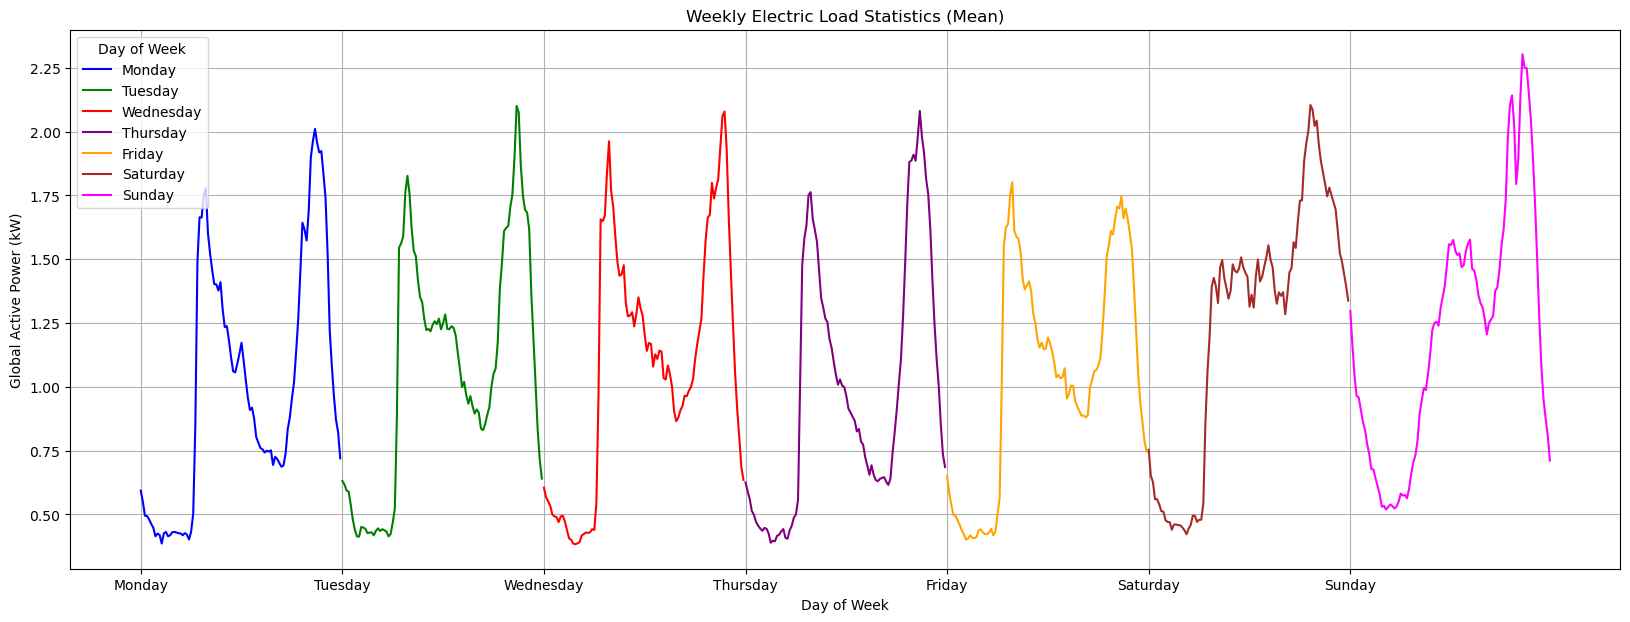

In [88]:
# Assuming data_resampled is already loaded and filtered
data_filtered = data_resampled['2006-12-18':'2010-11-26'].copy()

# Calculate the mean power consumption for each day
data_filtered['DayOfWeek'] = data_filtered.index.dayofweek
data_filtered['TimeOfDay'] = data_filtered.index.time

# Compute the mean for each day of the week at each time slot
weekly_mean = data_filtered.groupby(['DayOfWeek', 'TimeOfDay']).mean()['Global_active_power']

# Initialize a figure
plt.figure(figsize=(20, 7))
plt.title('Weekly Electric Load Statistics (Mean)')
plt.xlabel('Day of Week')
plt.ylabel('Global Active Power (kW)')

# Days mapping and plot settings
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'magenta']

# Plot each day's data sequentially
for i, day in enumerate(days_of_week):
    day_index = i * 96  # Assuming there are 96 time slots per day
    day_data = weekly_mean[weekly_mean.index.get_level_values('DayOfWeek') == i]
    
    # Extract time and power values
    times = np.arange(day_index, day_index + len(day_data))
    powers = day_data.values
    
    plt.plot(times, powers, label=day, color=colors[i])

plt.xticks(ticks=np.arange(0, 7*96, 96), labels=days_of_week)  # Set x-axis ticks to show days
plt.legend(title='Day of Week')
plt.grid(True)
plt.show()

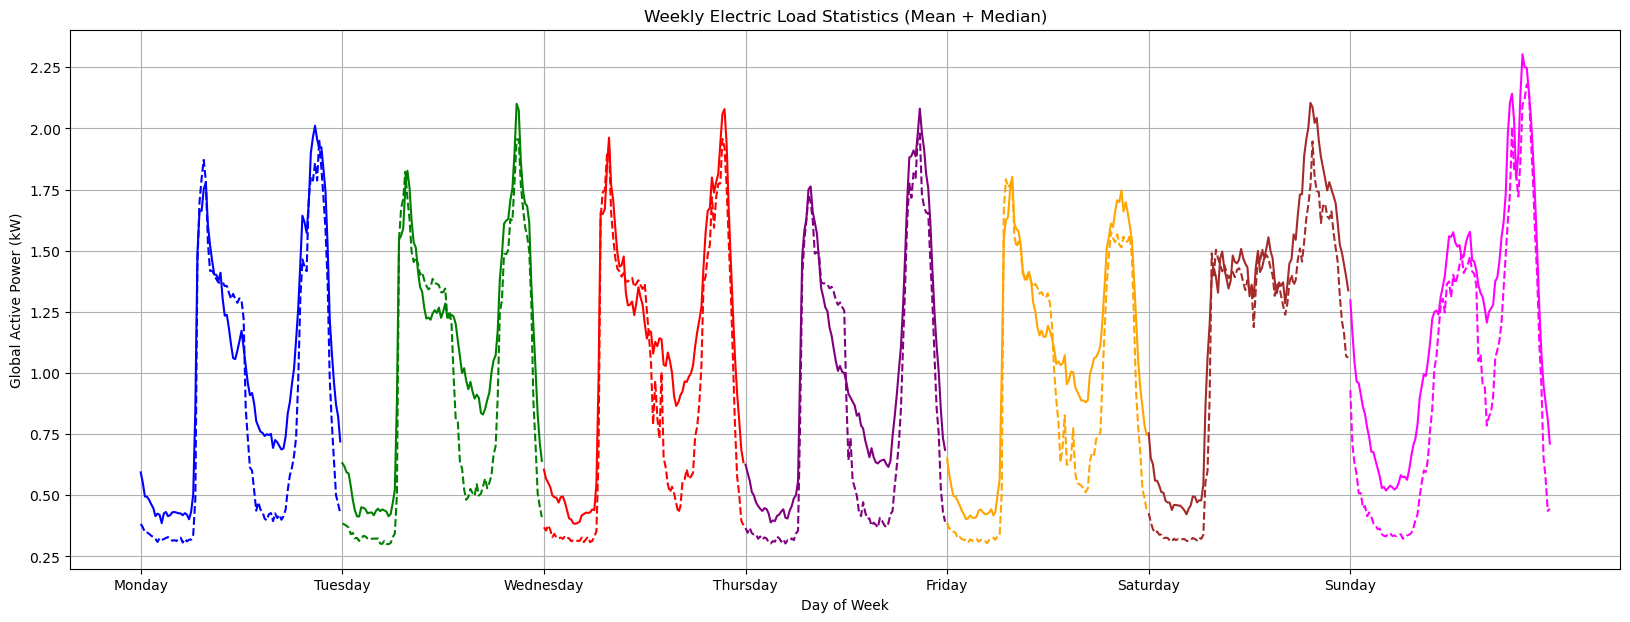

In [89]:
# Assuming data_resampled is already loaded and filtered
data_filtered = data_resampled['2006-12-18':'2010-11-26'].copy()

# Calculate the mean power consumption for each day
data_filtered['DayOfWeek'] = data_filtered.index.dayofweek
data_filtered['TimeOfDay'] = data_filtered.index.time

# Compute the mean and median for each day of the week at each time slot
weekly_stats = data_filtered.groupby(['DayOfWeek', 'TimeOfDay']).agg({'Global_active_power': ['mean', 'median']})

# Flatten the columns after aggregation
weekly_stats.columns = ['Mean', 'Median']

# Initialize a figure
plt.figure(figsize=(20, 7))
plt.title('Weekly Electric Load Statistics (Mean + Median)')
plt.xlabel('Day of Week')
plt.ylabel('Global Active Power (kW)')

# Days mapping and plot settings
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'magenta']

# Plot each day's data sequentially
for i, day in enumerate(days_of_week):
    day_index = i * 96  # Assuming there are 96 time slots per day
    day_data = weekly_stats[weekly_stats.index.get_level_values('DayOfWeek') == i]
    
    # Extract time, mean and median power values
    times = np.arange(day_index, day_index + len(day_data))
    mean_powers = day_data['Mean'].values
    median_powers = day_data['Median'].values
    
    # Plot mean and median
    plt.plot(times, mean_powers, label=f'Mean {day}', color=colors[i])
    plt.plot(times, median_powers, label=f'Median {day}', linestyle='--', color=colors[i])

plt.xticks(ticks=np.arange(0, 7*96, 96), labels=days_of_week)  # Set x-axis ticks to show days
#plt.legend(title='Day of Week')
plt.grid(True)
plt.show()

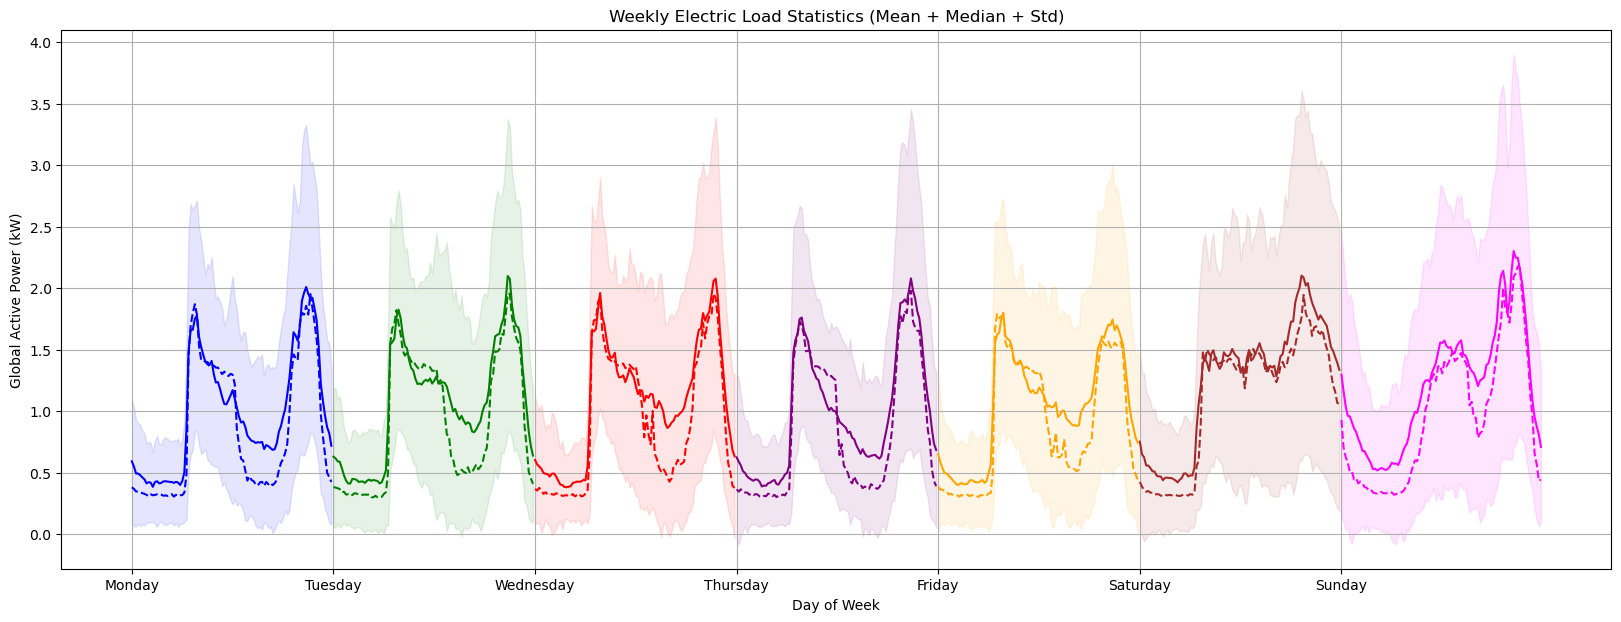

In [90]:
# Assuming data_resampled is already loaded and filtered
data_filtered = data_resampled['2006-12-18':'2010-11-26'].copy()

# Calculate the mean power consumption for each day
data_filtered['DayOfWeek'] = data_filtered.index.dayofweek
data_filtered['TimeOfDay'] = data_filtered.index.time

# Compute the mean, median, and standard deviation for each day of the week at each time slot
weekly_stats = data_filtered.groupby(['DayOfWeek', 'TimeOfDay']).agg({
    'Global_active_power': ['mean', 'median', 'std']
})

# Flatten the columns after aggregation
weekly_stats.columns = ['Mean', 'Median', 'Std']

# Initialize a figure
plt.figure(figsize=(20, 7))
plt.title('Weekly Electric Load Statistics (Mean + Median + Std)')
plt.xlabel('Day of Week')
plt.ylabel('Global Active Power (kW)')

# Days mapping and plot settings
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'magenta']

# Plot each day's data sequentially
for i, day in enumerate(days_of_week):
    day_index = i * 96  # Assuming there are 96 time slots per day
    day_data = weekly_stats[weekly_stats.index.get_level_values('DayOfWeek') == i]
    
    # Extract time, mean, median, and standard deviation power values
    times = np.arange(day_index, day_index + len(day_data))
    mean_powers = day_data['Mean'].values
    median_powers = day_data['Median'].values
    std_dev = day_data['Std'].values
    
    # Plot mean and median
    plt.plot(times, mean_powers, label=f'Mean {day}', color=colors[i])
    plt.plot(times, median_powers, label=f'Median {day}', linestyle='--', color=colors[i])
    
    # Fill between for standard deviation
    plt.fill_between(times, mean_powers - std_dev, mean_powers + std_dev, color=colors[i], alpha=0.1)

plt.xticks(ticks=np.arange(0, 7*96, 96), labels=days_of_week)  # Set x-axis ticks to show days
#plt.legend(title='Day of Week', loc='upper left')
plt.grid(True)
plt.show()

In [4]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138352 entries, 2006-12-16 17:15:00 to 2010-11-26 21:00:00
Data columns (total 1 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Global_active_power  138352 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [5]:
print(data_resampled.index.dtype)

datetime64[ns]


### Data is split into Training, Validation, and Test sets

In [6]:
# Split the data into training and test sets by holding out the last year
test_start_date = '2009-12-01'
train_data = data_resampled[:test_start_date]
test_data = data_resampled[test_start_date:]

# For validation, split the remaining training data by holding out one month every five months
train_indices = []
val_indices = []

current_date = train_data.index.min()
end_date = train_data.index.max()

while current_date <= end_date:
    month_start = current_date
    month_end = month_start + pd.DateOffset(months=1)
    five_month_end = month_start + pd.DateOffset(months=5)
    
    # Add the indices of the current month to validation, rest to train
    month_indices = train_data[month_start:month_end].index
    train_month_indices = train_data[month_end:five_month_end].index
    
    val_indices.extend(month_indices)
    train_indices.extend(train_month_indices)
    
    # Move current date by five months
    current_date = five_month_end

train_final = train_data.loc[train_indices]
val_final = train_data.loc[val_indices]

# Scaling the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_final.values) # train_final
val_scaled = scaler.transform(val_final.values)
test_scaled = scaler.transform(test_data.values)

# Display the first few rows of the resampled dataframe to verify
test_data.head(100)

,Global_active_power
Datetime,
2009-12-01 00:00:00,0.403467
2009-12-01 00:15:00,0.311333
2009-12-01 00:30:00,0.414533
2009-12-01 00:45:00,0.427067
2009-12-01 01:00:00,0.391600
...,...
2009-12-01 23:45:00,0.474000
2009-12-02 00:00:00,0.815200
2009-12-02 00:15:00,0.757333


In [7]:
# # Plotting the first 96 steps
# plt.figure(figsize=(12, 6))
# #plt.plot(predictions_array[:96], label='Predicted')
# plt.plot(test_data[:1000], label='Actual')
# plt.title('Comparison of Predictions and Actual Data for the First Day')
# plt.xlabel('Time Steps')
# plt.ylabel('Global Active Power')
# plt.legend()
# plt.grid(True)
# plt.show()

In [8]:
# for i in range(100):
#     print(test_data.iloc[i])

In [9]:
# testingJuicer = scaler.inverse_transform(test_scaled[0:10].reshape(-1, 1))
# print(testingJuicer)

### Change data from time-series unstructued to supervised learning task

In [10]:
# Function to create input sequences for one-step prediction
def create_sequences(input_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(input_data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 96  # Using past 96 steps to predict the next step

X_train, y_train = create_sequences(train_scaled, n_steps)
X_val, y_val = create_sequences(val_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

In [11]:
# X_test[0:1]
# # y_test[0:10]

In [12]:
# Convert to PyTorch tensors without specifying device here
train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
val_features = torch.tensor(X_val, dtype=torch.float32)
val_targets = torch.tensor(y_val, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)

# Data loader
train_loader = DataLoader(TensorDataset(train_features, train_targets), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(val_features, val_targets), batch_size=64, shuffle=False)

In [27]:
print(train_features.shape)
print(train_targets.shape)
print(val_features.shape)
print(val_targets.shape)
print(test_features.shape)
print(test_targets.shape)

torch.Size([81511, 96, 1])
torch.Size([81511, 1])
torch.Size([22114, 96, 1])
torch.Size([22114, 1])
torch.Size([34549, 96, 1])
torch.Size([34549, 1])


In [13]:
# print(test_features[0:1])
# print(test_features[1:2])
test_data.info

<bound method DataFrame.info of                      Global_active_power
Datetime                                
2009-12-01 00:00:00             0.403467
2009-12-01 00:15:00             0.311333
2009-12-01 00:30:00             0.414533
2009-12-01 00:45:00             0.427067
2009-12-01 01:00:00             0.391600
...                                  ...
2010-11-26 20:00:00             1.634533
2010-11-26 20:15:00             1.078933
2010-11-26 20:30:00             0.979200
2010-11-26 20:45:00             0.962133
2010-11-26 21:00:00             0.934667

[34645 rows x 1 columns]>

In [14]:
# # Plotting with a vertical line at the 96th step
# plt.figure(figsize=(14, 7))
# plt.title('Global Active Power over Two Days')
# plt.xlabel('Time Steps')
# plt.ylabel('Global Active Power (kW)')

# # Plot the first day (first 96 steps)
# plt.plot(rescaled_example, label='Actual Day 1', color='blue')

# # Plot the next day (next 96 steps)
# plt.plot(range(96, 192), rescaled_next_day, label='Actual Day 2', color='green')

# # Adding a vertical line at the 96th step to indicate the transition between two days
# plt.axvline(x=95, color='grey', linestyle='--', linewidth=1)

# plt.legend()
# plt.show()

In [15]:
# test_features[0:1]
# for i in range(10):
#     #print(test_targets[i])
#     testingJuicer = scaler.inverse_transform(test_targets[i].reshape(-1, 1))
#     print(testingJuicer)

In [45]:
# Check for MPS availability and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicting one step

    def forward(self, x):
        h0, c0 = (torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device),
                  torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device))
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking output of the last LSTM cell
        return out


model = LSTMModel(1, 20, 2).to(device)  # input_dim = 1, hidden_dim = 50, num_layers = 2
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)  # Removed verbose=True

start_time_epoch = time.time()
# Training loop with early stopping and learning rate scheduler
num_epochs = 30
best_val_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation and learning rate adjustments
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets.view(-1, 1)).item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    # Log learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}, Training Loss: {total_loss / len(train_loader)}, Validation Loss: {val_loss}, Learning Rate: {current_lr}')

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break



# Recursive Forecasting
model.eval()
test_predictions = test_features[0:1].to(device)  # Start with the first test input
predictions = []

for _ in range(len(test_targets)):
    with torch.no_grad():
        pred = model(test_predictions)
        predictions.append(pred.cpu().numpy().flatten()[0])
        new_input = torch.cat((test_predictions[:, 1:, :], pred.view(1, 1, 1)), dim=1)  # Append prediction
        test_predictions = new_input.to(device)
end_time_epoch = time.time()  # End time for the epoch
total_seconds = end_time_epoch - start_time_epoch
minutes = total_seconds // 60
seconds = total_seconds % 60
print(f'Training completed in {int(minutes)} minutes and {seconds:.2f} seconds')


# Calculate RMSE and MAE for the recursive forecast
test_targets_array = test_targets.cpu().numpy()
predictions_array = np.array(predictions)
rmse = np.sqrt(mean_squared_error(test_targets_array, predictions_array))
mae = mean_absolute_error(test_targets_array, predictions_array)
print(f'Test RMSE: {rmse}, Test MAE: {mae}')

Using device: mps
Epoch 1, Training Loss: 0.005647489010722609, Validation Loss: 0.004450711547967378, Learning Rate: 0.001
Epoch 2, Training Loss: 0.0041636634856357215, Validation Loss: 0.004302502385202009, Learning Rate: 0.001
Epoch 3, Training Loss: 0.004150131517435311, Validation Loss: 0.004246909697482906, Learning Rate: 0.001
Epoch 4, Training Loss: 0.004126709460714332, Validation Loss: 0.0042775248911169845, Learning Rate: 0.001
Epoch 5, Training Loss: 0.0041192682355597, Validation Loss: 0.0042698308575250385, Learning Rate: 0.001
Epoch 6, Training Loss: 0.004104487604795688, Validation Loss: 0.004279226760650484, Learning Rate: 0.001
Epoch 7, Training Loss: 0.004105175273848209, Validation Loss: 0.004271414382093872, Learning Rate: 0.001
Epoch 8, Training Loss: 0.004101538600098909, Validation Loss: 0.004237464156134372, Learning Rate: 0.001
Epoch 9, Training Loss: 0.004085542148456498, Validation Loss: 0.004247149513634675, Learning Rate: 0.001
Epoch 10, Training Loss: 0.

In [46]:
# # Assuming 'predictions' is a list of predicted values that have been scaled using MinMaxScaler
# nparr_predictions = np.array(predictions).reshape(-1, 1)  # Reshape for scaler compatibility

# # Rescale predictions back to the original scale
# rescaled_predictions = scaler.inverse_transform(nparr_predictions)

# # Print the first 10 rescaled predictions
# for i in range(30):
#     print(rescaled_predictions[i])

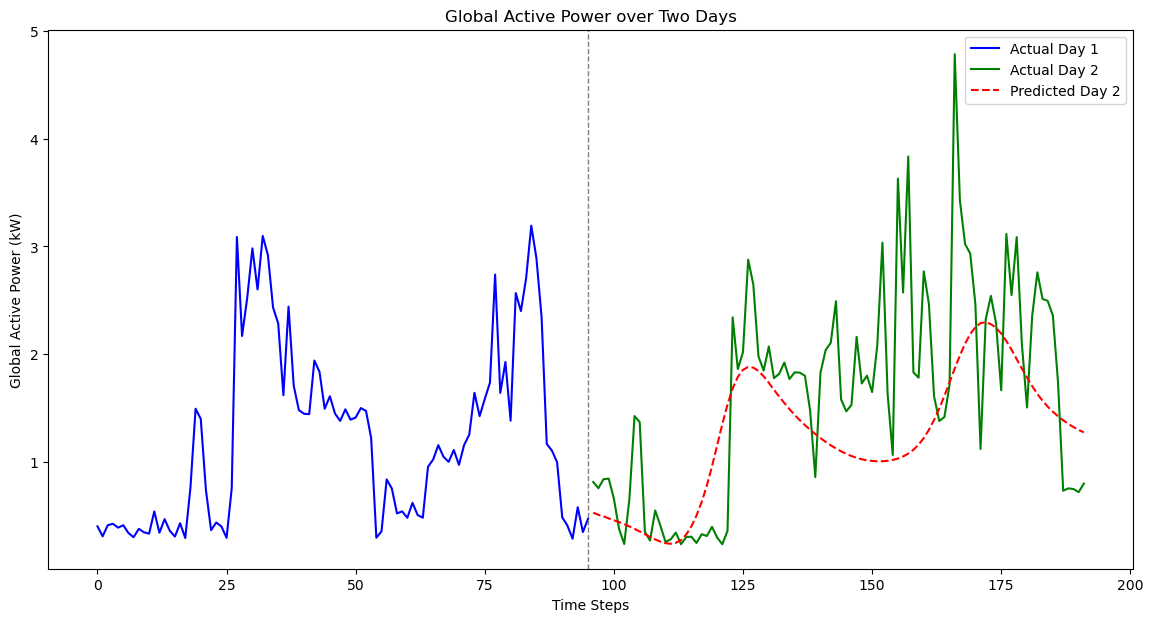

RMSE for the second day: 0.8346614837646484
MAE for the second day: 0.6079780459403992


In [47]:
# Convert the first sequence from test_features back to numpy array
test_features_numpy = test_features[0:1].numpy().reshape(-1, 1)
rescaled_example = scaler.inverse_transform(test_features_numpy).flatten()

# Assuming test_targets is correctly formatted and each row represents a single time step, reshape if necessary
next_day_true_values = test_targets[:96].numpy().flatten()  # Assuming test_targets has a shape of (n, )
rescaled_next_day = scaler.inverse_transform(next_day_true_values.reshape(-1, 1)).flatten()

# Assuming 'predictions' is a list of predicted values that have been scaled using MinMaxScaler
nparr_predictions = np.array(predictions).reshape(-1, 1)  # Reshape for scaler compatibility
rescaled_predictions = scaler.inverse_transform(nparr_predictions).flatten()  # Rescale and flatten for plotting

# Plotting with a vertical line at the 96th step
plt.figure(figsize=(14, 7))
plt.title('Global Active Power over Two Days')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kW)')

# Plot the first day (first 96 steps)
plt.plot(rescaled_example, label='Actual Day 1', color='blue')

# Plot the next day (next 96 steps)
plt.plot(range(96, 192), rescaled_next_day, label='Actual Day 2', color='green')
# Plot the first 96 predicted steps overlapping with the second day
plt.plot(range(96, 192), rescaled_predictions[:96], label='Predicted Day 2', color='red', linestyle='--')

# Adding a vertical line at the 96th step to indicate the transition between two days
plt.axvline(x=95, color='grey', linestyle='--', linewidth=1)

plt.legend()
plt.show()

# Actual and predicted values for the second day
actual_day_2 = rescaled_next_day
predicted_day_2 = rescaled_predictions[:96]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_day_2, predicted_day_2))

# Calculate MAE
mae = mean_absolute_error(actual_day_2, predicted_day_2)

print(f'RMSE for the second day: {rmse}')
print(f'MAE for the second day: {mae}')

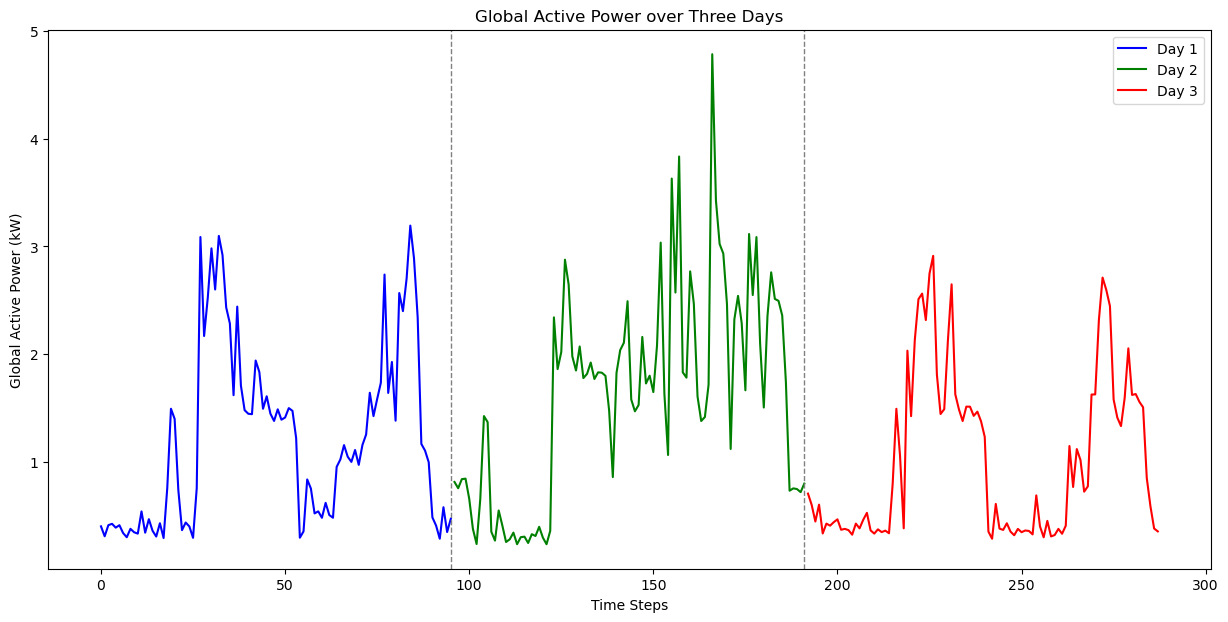

In [91]:
# Extracting the first 288 steps (three days) from the test data
three_days_data = test_data['Global_active_power'].head(288).values

# Plotting the data
plt.figure(figsize=(15, 7))
plt.title('Global Active Power over Three Days')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kW)')

# Plot the first day (first 96 steps)
plt.plot(three_days_data[:96], label='Day 1', color='blue')

# Add a vertical line to indicate the end of the first day
plt.axvline(x=95, color='grey', linestyle='--', linewidth=1)

# Plot the second day (next 96 steps)
plt.plot(range(96, 192), three_days_data[96:192], label='Day 2', color='green')

# Add another vertical line to indicate the end of the second day
plt.axvline(x=191, color='grey', linestyle='--', linewidth=1)

# Plot the third day (final 96 steps)
plt.plot(range(192, 288), three_days_data[192:], label='Day 3', color='red')

plt.legend()
plt.show()


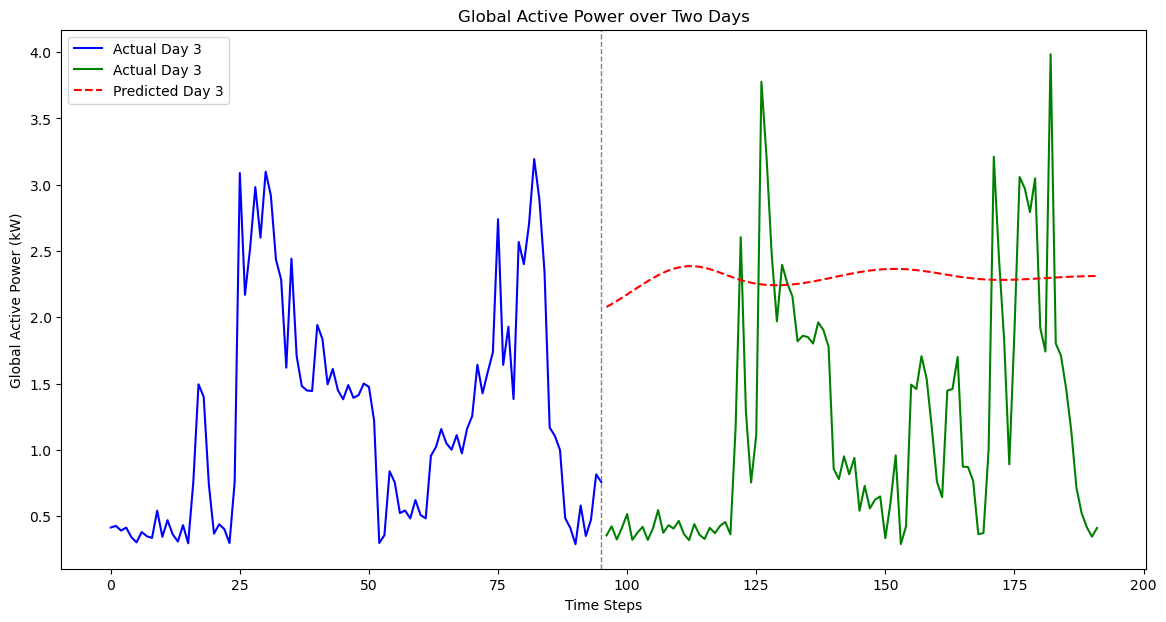

RMSE for the third day: 1.4337931871414185
MAE for the third day: 1.2914519309997559


In [92]:
test_features_numpy = test_features[2:3].numpy().reshape(-1, 1)
rescaled_example = scaler.inverse_transform(test_features_numpy).flatten()

next_day_true_values = test_targets[192:288].numpy().flatten()  # Assuming test_targets has a shape of (n, )
rescaled_next_day = scaler.inverse_transform(next_day_true_values.reshape(-1, 1)).flatten()

# Plotting with a vertical line at the 96th step
plt.figure(figsize=(14, 7))
plt.title('Global Active Power over Two Days')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kW)')
# Plot the third day (third 96 steps)
plt.plot(rescaled_example, label='Actual Day 3', color='blue')

# Plot the next day (next 96 steps)
plt.plot(range(96, 192), rescaled_next_day, label='Actual Day 3', color='green')

# Plot the first 96 predicted steps overlapping with the second day
plt.plot(range(96, 192), rescaled_predictions[192:288], label='Predicted Day 3', color='red', linestyle='--')

# Adding a vertical line at the 96th step to indicate the transition between two days
plt.axvline(x=95, color='grey', linestyle='--', linewidth=1)

plt.legend()
plt.show()

# Actual and predicted values for the second day
actual_day_3 = rescaled_next_day
predicted_day_3 = rescaled_predictions[192:288]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_day_3, predicted_day_3))

# Calculate MAE
mae = mean_absolute_error(actual_day_3, predicted_day_3)

print(f'RMSE for the third day: {rmse}')
print(f'MAE for the third day: {mae}')

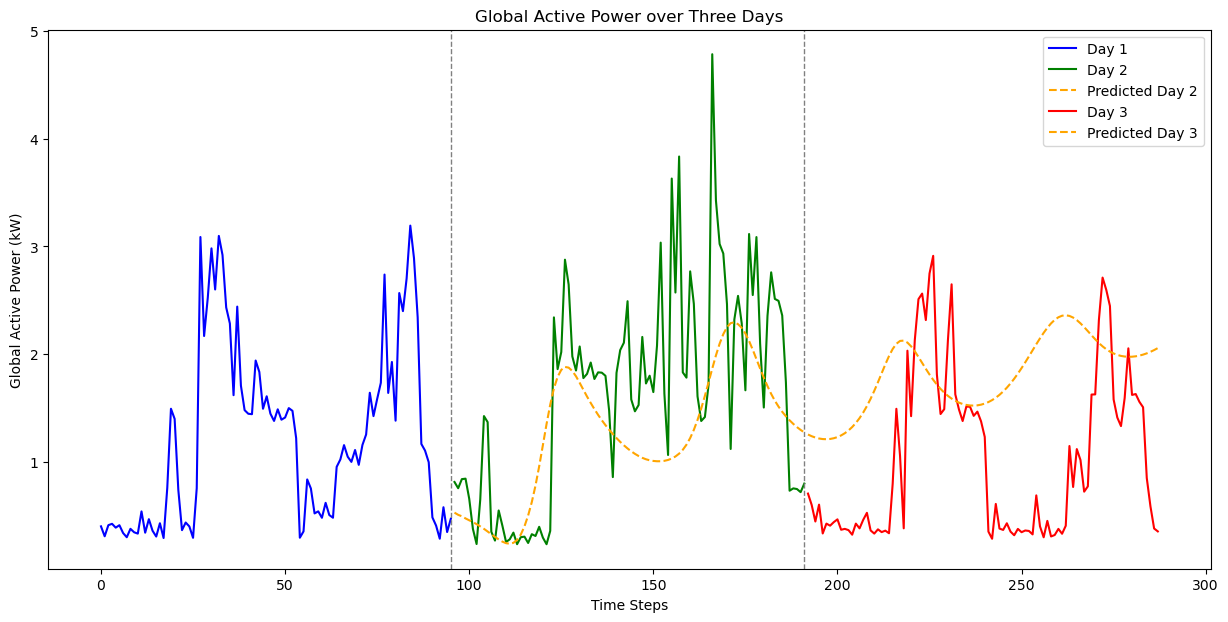

In [93]:
import matplotlib.pyplot as plt

# Extracting the first 288 steps (three days) from the test data
three_days_data = test_data['Global_active_power'].head(288).values

# Plotting the data
plt.figure(figsize=(15, 7))
plt.title('Global Active Power over Three Days')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kW)')

# Plot the first day (first 96 steps)
plt.plot(three_days_data[:96], label='Day 1', color='blue')

# Add a vertical line to indicate the end of the first day
plt.axvline(x=95, color='grey', linestyle='--', linewidth=1)

# Plot the second day (next 96 steps)
plt.plot(range(96, 192), three_days_data[96:192], label='Day 2', color='green')
# Plot the first 96 predicted steps overlapping with the second day
plt.plot(range(96, 192), rescaled_predictions[:96], label='Predicted Day 2', color='orange', linestyle='--')

# Add another vertical line to indicate the end of the second day
plt.axvline(x=191, color='grey', linestyle='--', linewidth=1)

# Plot the third day (final 96 steps)
plt.plot(range(192, 288), three_days_data[192:], label='Day 3', color='red')
plt.plot(range(192, 288), rescaled_predictions[96:192], label='Predicted Day 3', color='orange', linestyle='--')

plt.legend()
plt.show()

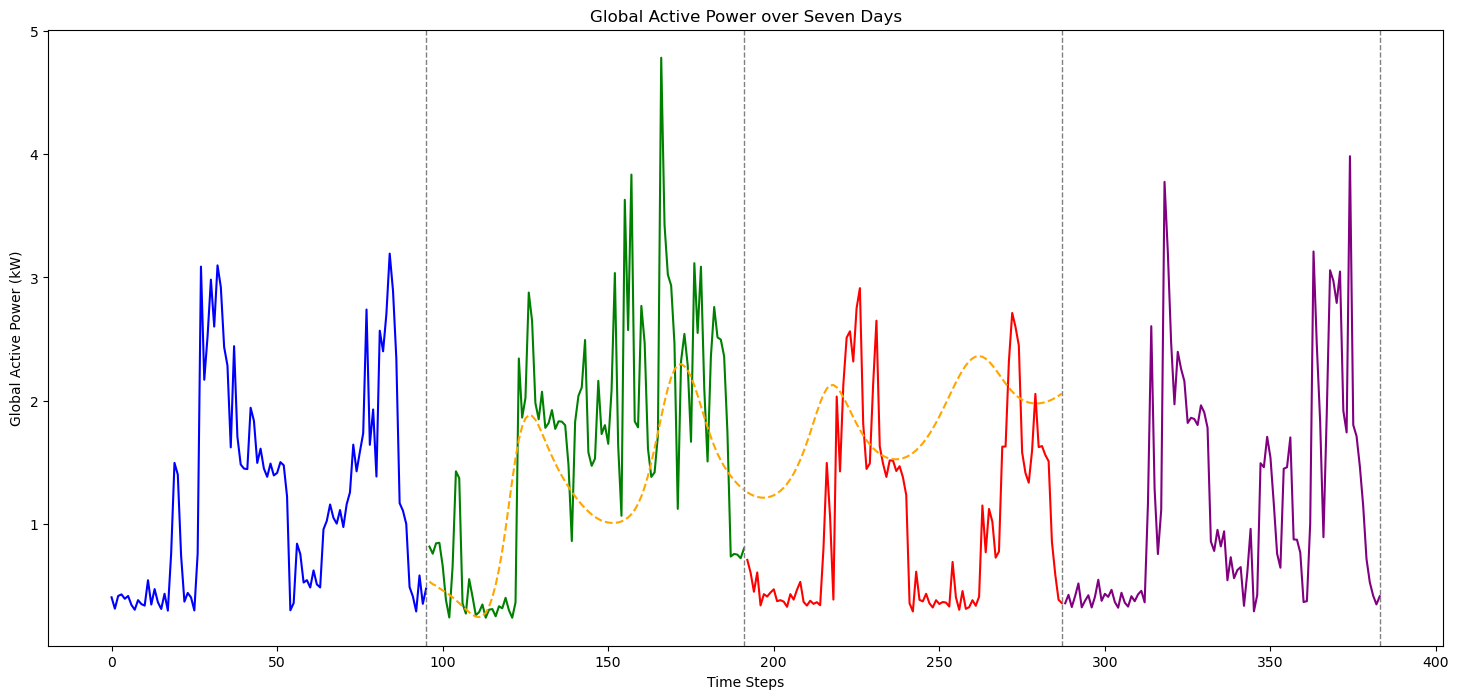

In [94]:
import matplotlib.pyplot as plt

# Extracting the first 672 steps (seven days) from the test data
seven_days_data = test_data['Global_active_power'].head(672).values

# Plotting the data
plt.figure(figsize=(18, 8))
plt.title('Global Active Power over Seven Days')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power (kW)')

# Define colors for each day for clarity
colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'orange']

# Loop to plot each day
for i in range(4):
    start = i * 96
    end = start + 96
    plt.plot(range(start, end), seven_days_data[start:end], label=f'Day {i+1}', color=colors[i])
    if i < 6:  # Add vertical lines except after the last day
        plt.axvline(x=end - 1, color='grey', linestyle='--', linewidth=1)

plt.plot(range(96, 192), rescaled_predictions[:96], label='Predicted Day 2', color='orange', linestyle='--')
plt.plot(range(192, 288), rescaled_predictions[96:192], label='Predicted Day 3', color='orange', linestyle='--')

In [ ]:
# Assuming 'scaler' is your MinMaxScaler instance and it's already fitted to the original data
# Convert predictions and targets back to the original scale
test_targets_rescaled = scaler.inverse_transform(test_targets_array.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions_array.reshape(-1, 1))

# Plotting the first 96 steps
plt.figure(figsize=(12, 6))
plt.plot(predictions_rescaled[:96], label='Predicted')
plt.plot(test_targets_rescaled[:96], label='Actual')
plt.title('Comparison of Predictions and Actual Data for the First Day')
plt.xlabel('Time Steps')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Constants for the number of steps per day
steps_per_day = 96
#print(test_targets_rescaled[:steps_per_day])
# Ensure we have enough data points
if len(test_targets_rescaled) >= 2 * steps_per_day and len(predictions_rescaled) >= steps_per_day:
    plt.figure(figsize=(14, 7))
    plt.title('Forecasting Global Active Power for Two Days')
    plt.xlabel('Time Steps')
    plt.ylabel('Global Active Power (kW)')

    # Plotting the first day of actual data
    plt.plot(test_targets_rescaled[:steps_per_day], label='Actual Day 1', color='blue')
    
    # Adding a vertical line to separate the two days
    plt.axvline(x=steps_per_day - 1, color='grey', linestyle='--', linewidth=1)
    
    # Plotting the second day of actual data
    plt.plot(range(steps_per_day, 2 * steps_per_day), test_targets_rescaled[steps_per_day:2 * steps_per_day], label='Actual Day 2', color='green')
    
    # Plotting the predictions for the second day
    plt.plot(range(steps_per_day, 2 * steps_per_day), predictions_rescaled[:steps_per_day], label='Predicted Day 2', color='red')

    plt.legend()
    plt.show()

else:
    print("Not enough data to plot two full days.")


In [ ]:
# # Rescale the predicted and actual values to their original scale
# predictions_array_rescaled = scaler.inverse_transform(predictions_array.reshape(-1, 1)).flatten()
# test_targets_array_rescaled = scaler.inverse_transform(test_targets_array.reshape(-1, 1)).flatten()

# # Calculate RMSE and MAE for the recursive forecast on the rescaled data
# rmse = np.sqrt(mean_squared_error(test_targets_array_rescaled, predictions_array_rescaled))
# mae = mean_absolute_error(test_targets_array_rescaled, predictions_array_rescaled)
# print(f'Test RMSE: {rmse}, Test MAE: {mae}')

# # Plot the first 96 steps (1 day)
# plt.figure(figsize=(14, 7))
# plt.plot(predictions_array_rescaled[:96], label='Predicted', color='blue', marker='o')
# plt.plot(test_targets_array_rescaled[:96], label='Actual', color='red', marker='x')
# plt.title('Comparison of Predictions and Actual Data for the First 96 Time Steps')
# plt.xlabel('Time Step')
# plt.ylabel('Global Active Power')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot full series to see overall performance
# plt.figure(figsize=(14, 7))
# plt.plot(predictions_array_rescaled, label='Predicted', color='blue', linewidth=2)
# plt.plot(test_targets_array_rescaled, label='Actual', color='red', linewidth=2)
# plt.title('Full Series Comparison of Predictions and Actual Data')
# plt.xlabel('Time Step')
# plt.ylabel('Global Active Power')
# plt.legend()
# plt.grid(True)
# plt.show()

# print(predictions_array_rescaled[:96])
# print(test_targets_array_rescaled[:96])